# The Future is Now: Patterns in Global Temperature Trends Across the World

Continued from `Analysis 2 Cluster k-means.ipynb`.

## Dependency Installation & Imports

In [1]:
%pip install pandas numpy scikit-learn matplotlib missingno pyarrow pycountry_convert kgcpy scipy fastdtw statsmodels networkx pyvis

Note: you may need to restart the kernel to use updated packages.


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import linregress
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
pd.set_option('display.max_rows', 12)
pd.set_option('display.max_columns', None)
global_correlation = 0.895059831369191

## Further Pattern Examination

### Data Preparation (Standardization)

In [6]:
with open('Data_augmented.csv', 'r', encoding='utf-8') as file:
    df = pd.read_csv(file, encoding='utf-8')

df.head()

,City,Year,AverageTemperature,Country,Latitude,Longitude,NumericLatitude,NumericLongitude,AbsLatitude,AbsLongitude,Continent,kcc
0,A Coruña,1880,12.837750,Spain,43.3709703N,8.3959425W,43.37097,-8.395943,43.37097,8.395943,Europe,Csb
1,A Coruña,1881,13.405000,Spain,43.3709703N,8.3959425W,43.37097,-8.395943,43.37097,8.395943,Europe,Csb
2,A Coruña,1882,12.776250,Spain,43.3709703N,8.3959425W,43.37097,-8.395943,43.37097,8.395943,Europe,Csb
3,A Coruña,1883,12.260833,Spain,43.3709703N,8.3959425W,43.37097,-8.395943,43.37097,8.395943,Europe,Csb
4,A Coruña,1884,12.693250,Spain,43.3709703N,8.3959425W,43.37097,-8.395943,43.37097,8.395943,Europe,Csb


In [7]:
def calculate_corr(df):
    corr_matrix = df[['Year', 'AverageTemperature']].corr()
    return corr_matrix.loc['Year', 'AverageTemperature']

grouped = df.groupby(['City', 'Country']).apply(calculate_corr).reset_index(name='corr')

df = df.merge(grouped, on=['City', 'Country'], how='left')

scaler = MinMaxScaler()
df['AbsLatitude_scaled'] = scaler.fit_transform(df[['AbsLatitude']])

clustering_df = df[['City', 'Country', 'corr', 'AbsLatitude_scaled']].drop_duplicates()

X = clustering_df[['corr', 'AbsLatitude_scaled']].values

C:\Users\jacob\AppData\Local\Temp\ipykernel_23888\1584961914.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby(['City', 'Country']).apply(calculate_corr).reset_index(name='corr')


### Hierarchical Clustering

Create a dendrogam to help estimate how many clusters to use; could find the largest vertical distance that does not intersect any clusters.

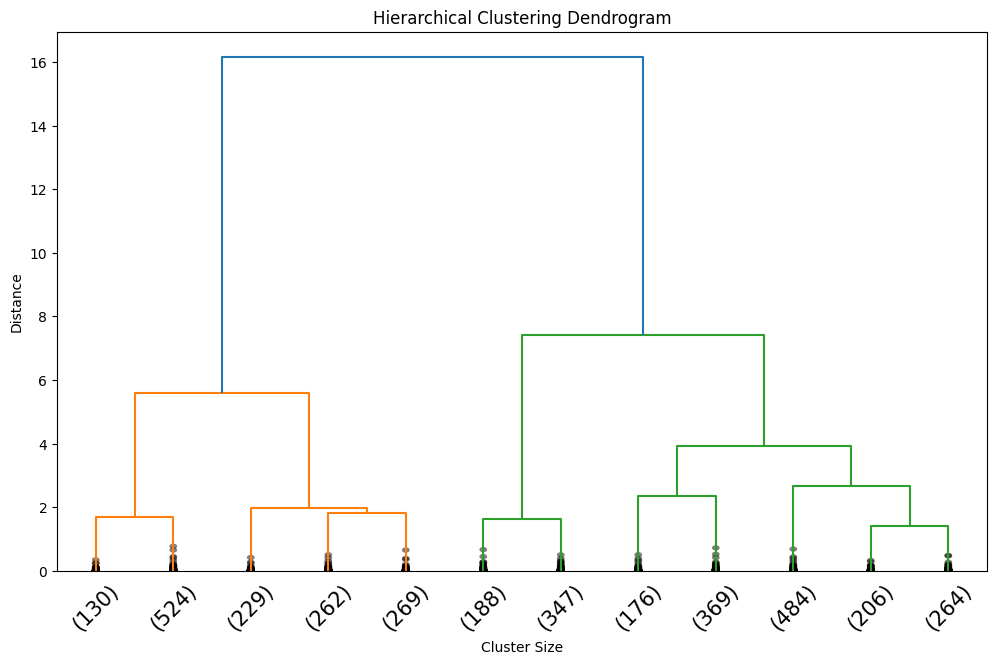

In [9]:
Z = linkage(X, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 7))
dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=15., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.5154
For n_clusters = 3, the average silhouette_score is : 0.4496
For n_clusters = 4, the average silhouette_score is : 0.3983
For n_clusters = 5, the average silhouette_score is : 0.3829
For n_clusters = 6, the average silhouette_score is : 0.3909
For n_clusters = 7, the average silhouette_score is : 0.4109
For n_clusters = 8, the average silhouette_score is : 0.3728
For n_clusters = 9, the average silhouette_score is : 0.3819
For n_clusters = 10, the average silhouette_score is : 0.3859
For n_clusters = 11, the average silhouette_score is : 0.3622
For n_clusters = 12, the average silhouette_score is : 0.3535
For n_clusters = 13, the average silhouette_score is : 0.3520
For n_clusters = 14, the average silhouette_score is : 0.3458
For n_clusters = 15, the average silhouette_score is : 0.3410
For n_clusters = 16, the average silhouette_score is : 0.3407
For n_clusters = 17, the average silhouette_score is : 0.3450
For n_clusters =

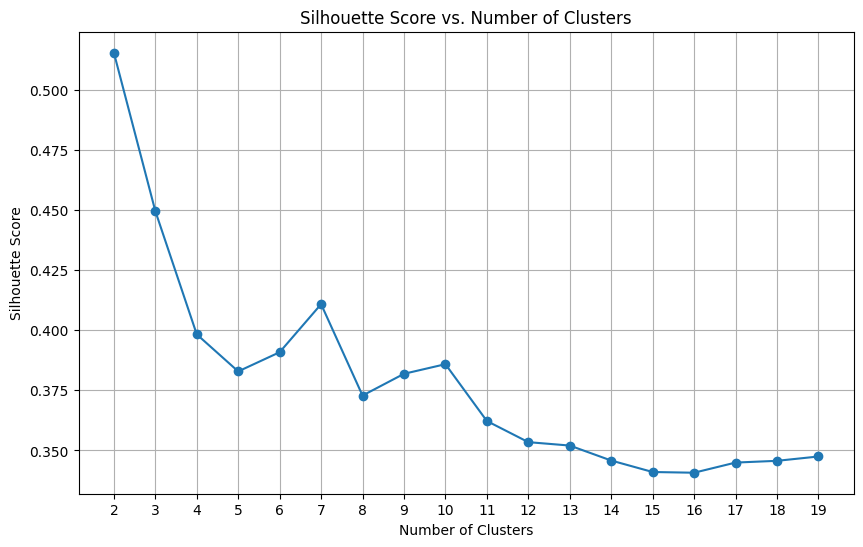

In [11]:
silhouette_scores = []

# Calculate silhouette scores for different numbers of clusters
for n_clusters in range(2, 20):
    labels = fcluster(Z, n_clusters, criterion='maxclust')
    
    # Calculate silhouette score only if there are 2 or more clusters
    if len(set(labels)) > 1:
        silhouette_avg = silhouette_score(X, labels)
        silhouette_scores.append(silhouette_avg)
        print(f'For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg:.4f}')
    else:
        # Append a None or a negative value if there aren't enough clusters to compute a valid silhouette score
        silhouette_scores.append(None)
        print(f'For n_clusters = {n_clusters}, there are not enough clusters for silhouette score.')

# Now, plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 20), silhouette_scores, marker='o')
plt.xticks(range(2, 20))
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

From the graph it looks like 7 clusters might be the sweet spot.

The plot agrees with our calculation - it looks like 7 is the optimal number of clusters. Let's continue.

In [13]:
# Perform the clustering with the optimal number of clusters
n_clusters = 7
hierarchical_labels = fcluster(Z, n_clusters, criterion='maxclust')

# Add the cluster labels to your clustering_df DataFrame
clustering_df['Cluster'] = hierarchical_labels

# Before merging, make sure that 'City' and 'Country' are the only index in clustering_df
clustering_df.set_index(['City', 'Country'], inplace=True)

In [17]:
silhouette_avg = silhouette_score(X, hierarchical_labels)
calinski_harabasz = calinski_harabasz_score(X, hierarchical_labels)
davies_bouldin = davies_bouldin_score(X, hierarchical_labels)

print(f'Silhouette Score for {n_clusters} clusters: {silhouette_avg:.2f}')
print(f'Calinski-Harabasz Index: {calinski_harabasz:.2f}')
print(f'Davies-Bouldin Index: {davies_bouldin:.2f}')

Silhouette Score for 7 clusters: 0.41
Calinski-Harabasz Index: 6046.10
Davies-Bouldin Index: 0.76


In [14]:
df_hierarchical = pd.merge(df, clustering_df, on='City', how='left').drop_duplicates(subset='City', keep='first')
df_hierarchical = df_hierarchical[['Country', 'NumericLatitude', 'NumericLongitude', 'Continent', 'kcc', 'City', 'Cluster']]

df_hierarchical = df_hierarchical.sort_values(by=['Cluster', 'City']).reset_index(drop=True)

outfile = 'Data_hierarchical.csv'
df_hierarchical.to_csv(f'{outfile}', index=False)

print(f'Exported clustered cities to {outfile}')

Exported clustered cities to Data_hierarchical.csv


#### Cluster visualizations

1. Unique Cities in each cluster
2. Unique Countries in each cluster
3. Proportion of Continents in each cluster relative to all data
   1. Bar graph with absolute abundance
   2. Heat map with relative abundance
4. Proportion of climates in each cluster relative to all data
   1. Bar graph with absolute abundance
   2. Heat map with relative abundance
5. For each cluster:
   1. Averaged AverageTemperature by Year & correlations
   2. AverageTemperature by Year & correlations
   3. Box & Whiskers plots to look at geographic spread (Latitude, Longitude)

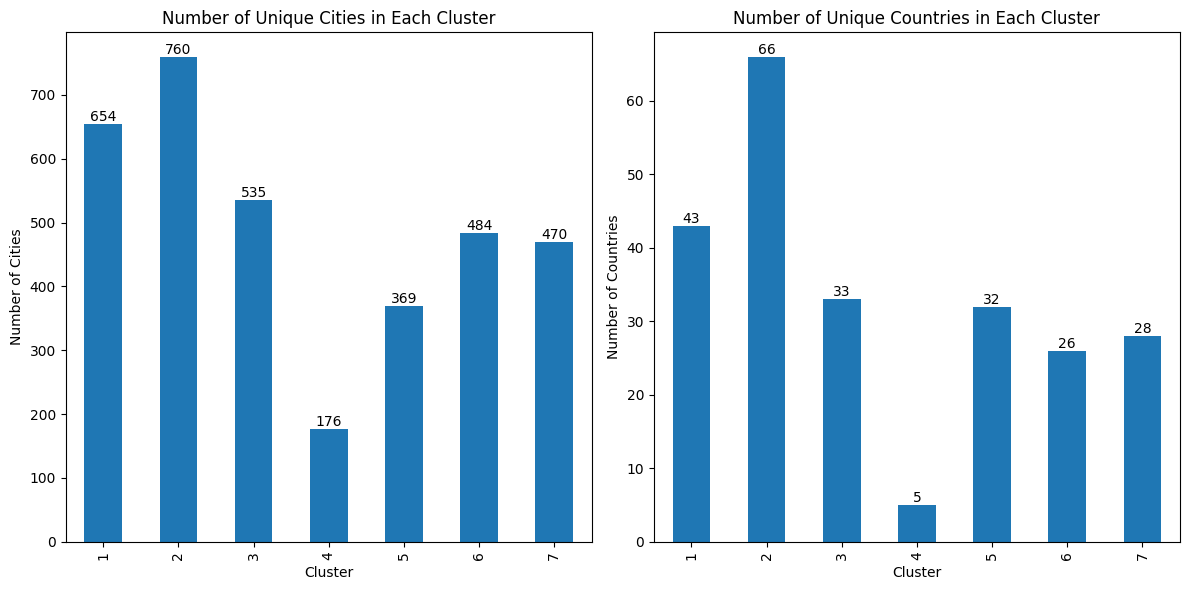

In [15]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
cities_per_cluster = df_hierarchical.groupby('Cluster')['City'].nunique()
cities_per_cluster.plot(kind='bar')
plt.title('Number of Unique Cities in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Cities')
for index, value in enumerate(cities_per_cluster):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.subplot(1, 2, 2)
countries_per_cluster = df_hierarchical.groupby('Cluster')['Country'].nunique()
countries_per_cluster.plot(kind='bar')
plt.title('Number of Unique Countries in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Countries')
for index, value in enumerate(countries_per_cluster):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Visualize each averaged cluster

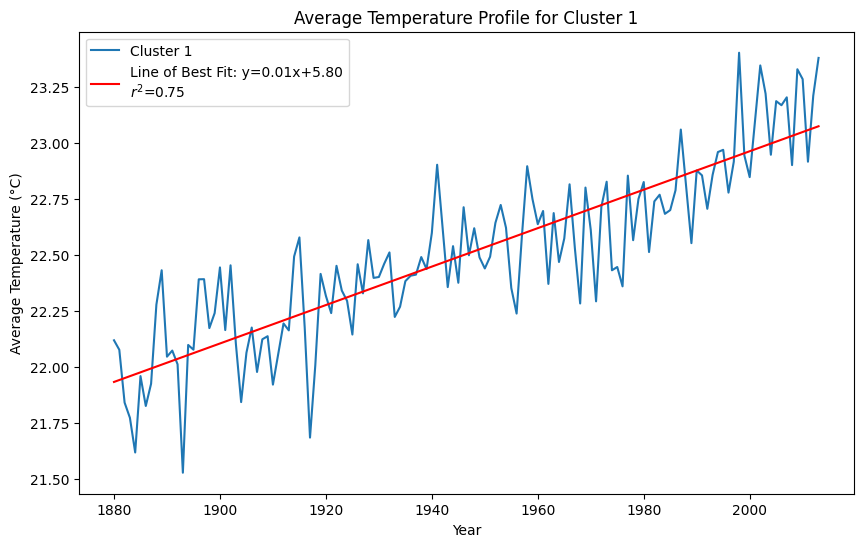

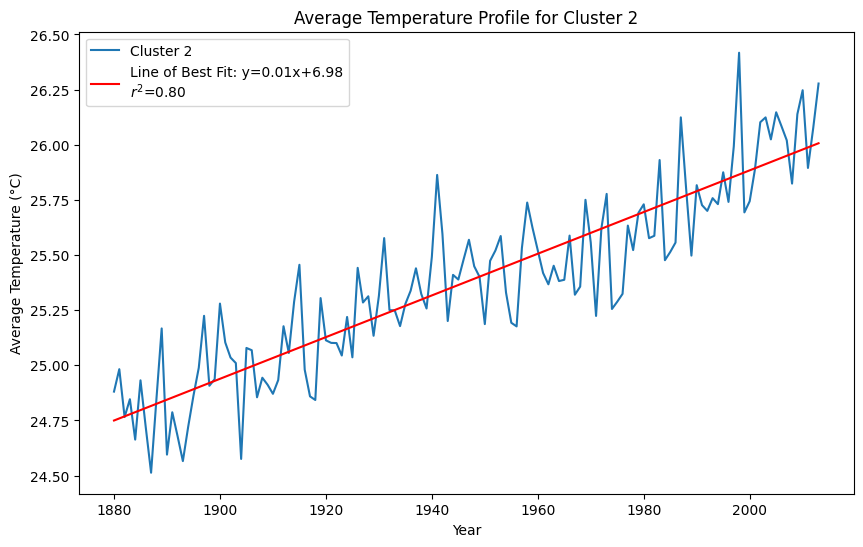

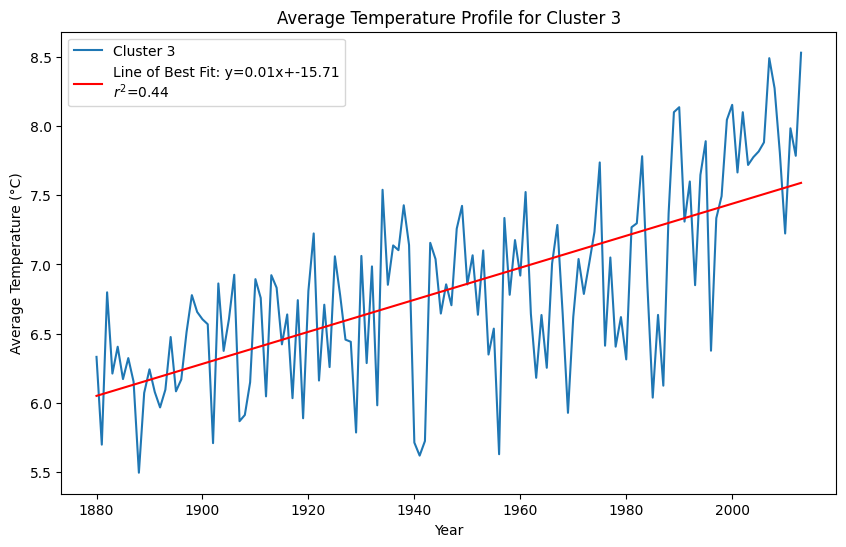

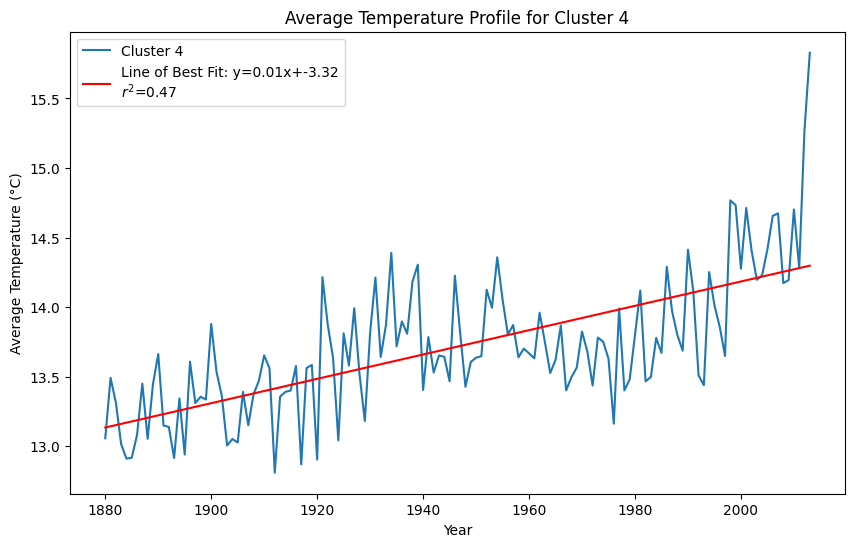

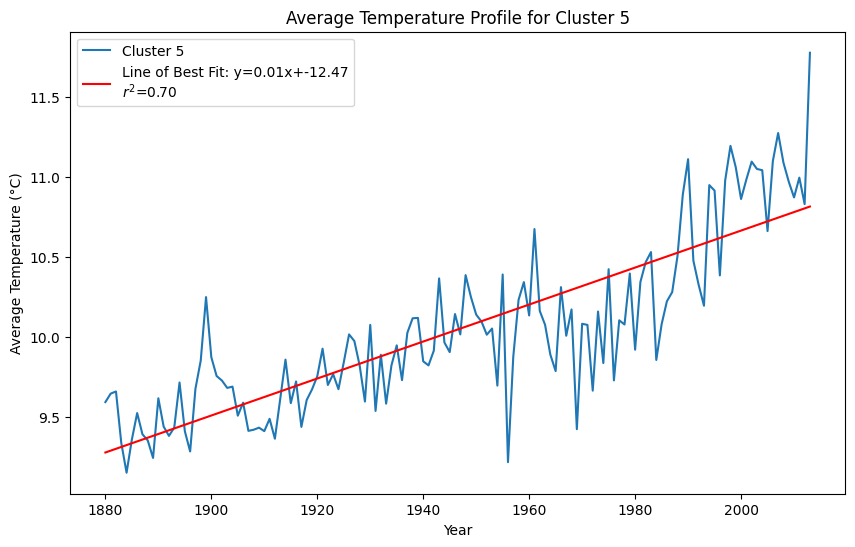

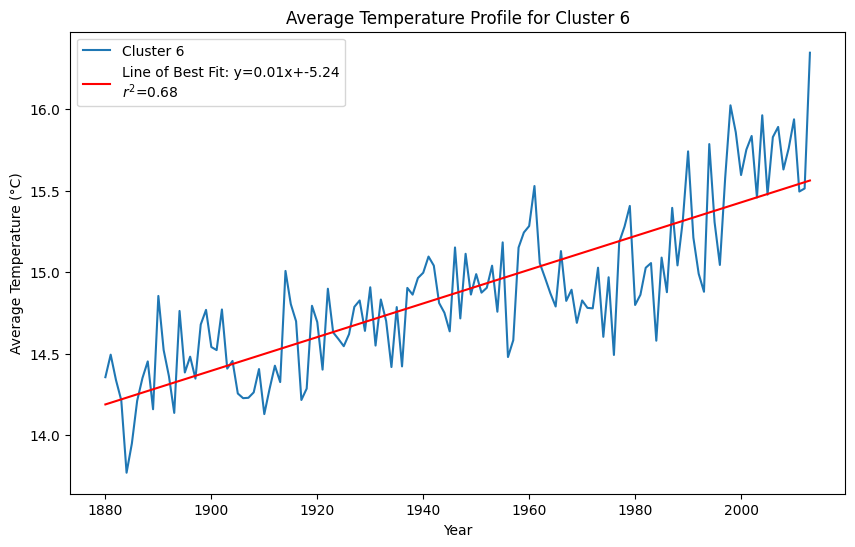

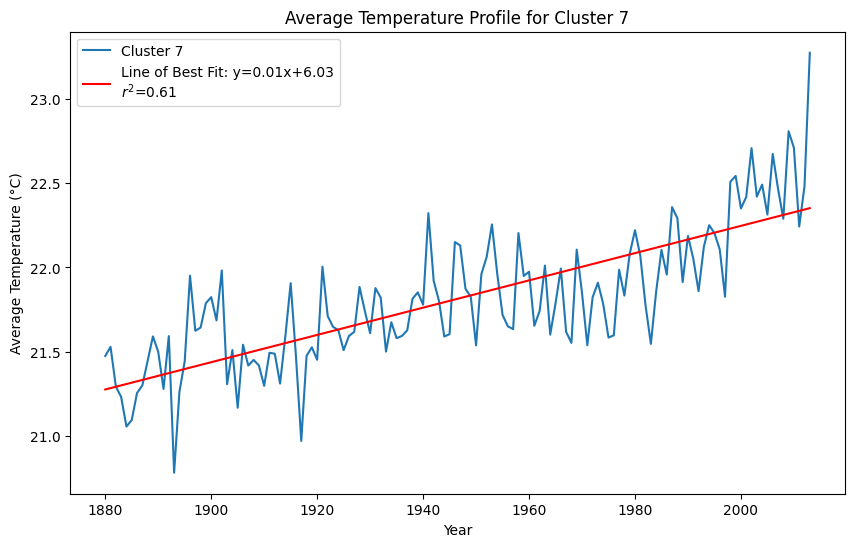

In [28]:
df_merged = pd.merge(df, df_hierarchical[['City', 'Country', 'Cluster']], on=['City', 'Country'], how='left')

for cluster in range(1, n_clusters + 1):
    # Extract cities belonging to the current cluster
    cluster_data = df_merged[df_merged['Cluster'] == cluster]
    
    # Group by year to obtain average temperature per year for the cluster
    yearly_temps = cluster_data.groupby('Year')['AverageTemperature'].mean().reset_index()

    # Plotting the yearly average temperatures
    plt.figure(figsize=(10, 6))
    plt.plot(yearly_temps['Year'], yearly_temps['AverageTemperature'], linestyle='-', label=f'Cluster {cluster}')

    # Line of best fit
    slope, intercept, r_value, _, _ = linregress(yearly_temps['Year'], yearly_temps['AverageTemperature'])
    line = slope * yearly_temps['Year'] + intercept
    plt.plot(yearly_temps['Year'], line, 'r', label=f'Line of Best Fit: y={slope:.2f}x+{intercept:.2f}\n$r^2$={r_value**2:.2f}')
    
    plt.title(f'Average Temperature Profile for Cluster {cluster}')
    plt.xlabel('Year')
    plt.ylabel('Average Temperature (°C)')
    plt.legend()
    plt.show()

View clusters

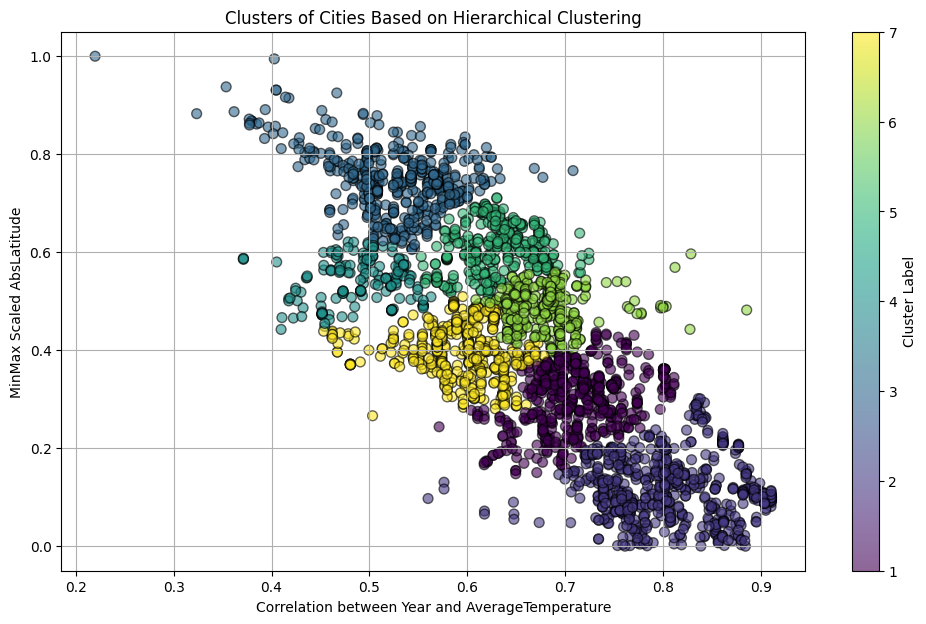

In [29]:
plt.figure(figsize=(12, 7))

# Assuming df_with_clusters already contains the 'Cluster' labels from hierarchical clustering
plt.scatter(clustering_df['corr'], clustering_df['AbsLatitude_scaled'], c=clustering_df['Cluster'], cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)

plt.title('Clusters of Cities Based on Hierarchical Clustering')
plt.xlabel('Correlation between Year and AverageTemperature')
plt.ylabel('MinMax Scaled AbsLatitude')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()


Relative abundance of Continents for each cluster vs. unclustered data

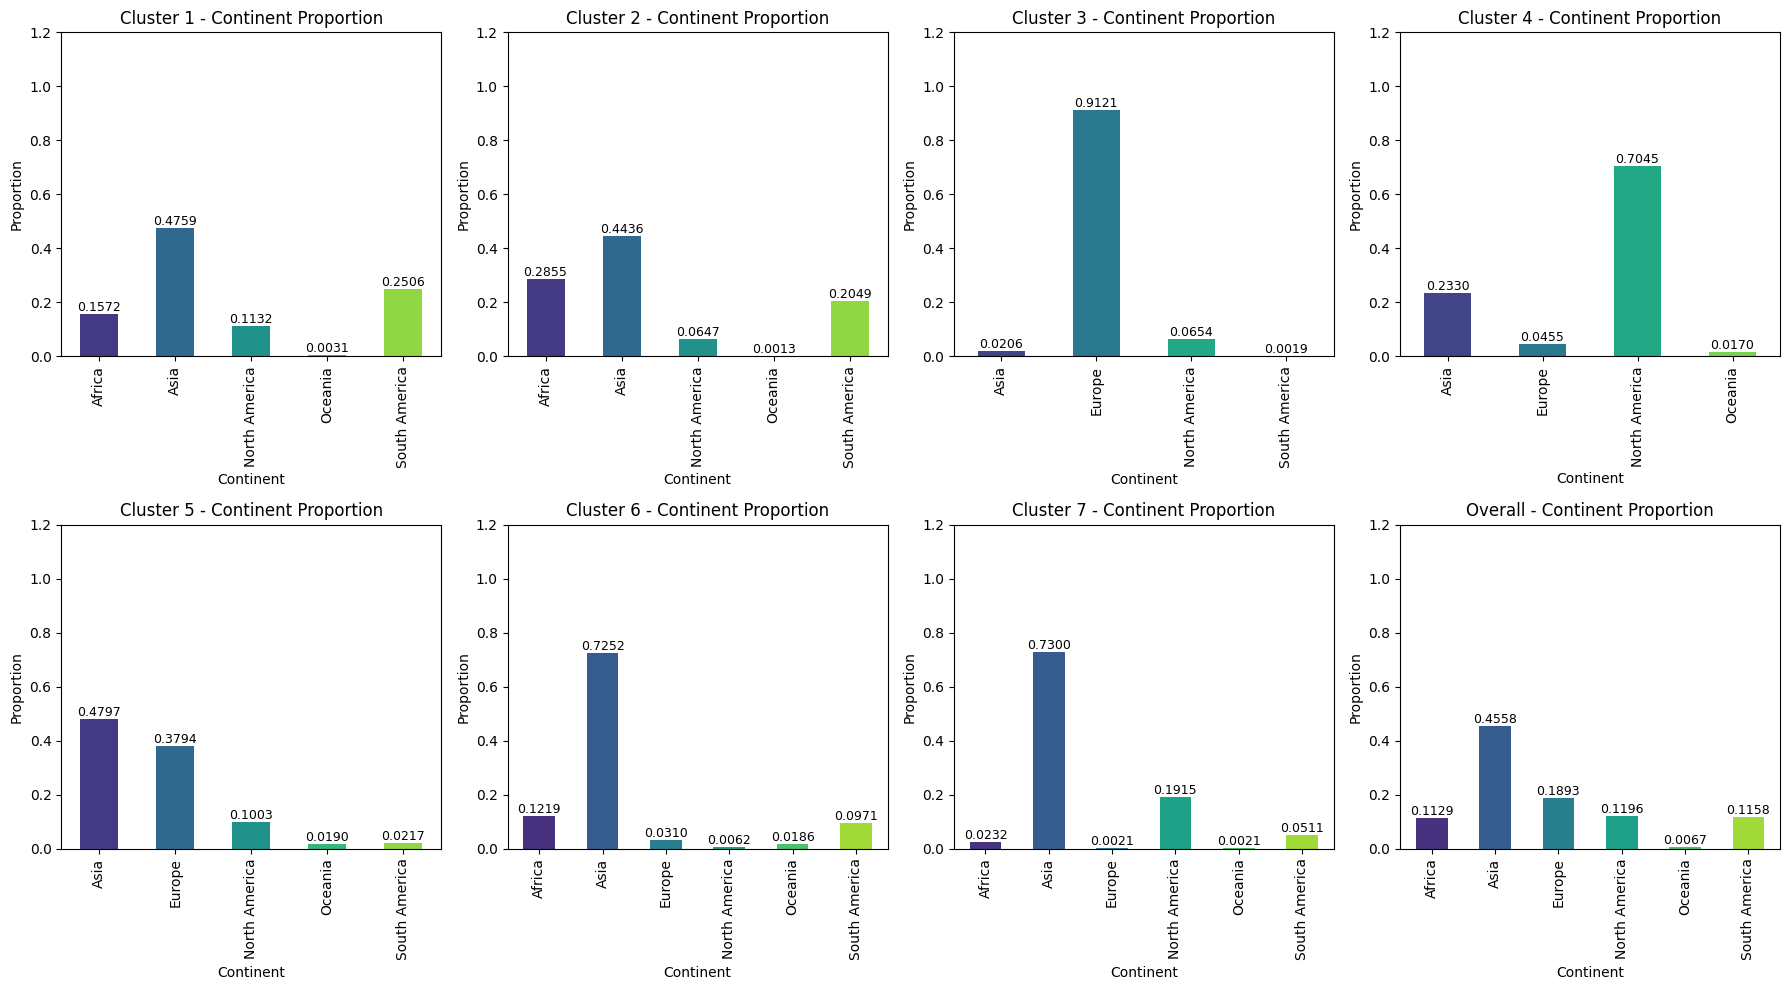

In [32]:
fig, axs = plt.subplots(2, 4, figsize=(18, 10))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

def add_labels(ax, series):
    for index, (label, value) in enumerate(series.items()):
        ax.text(index, value, f"{value:.4f}", ha='center', va='bottom', fontsize=9, color='black')

for i in range(1, n_clusters + 1):
    ax = axs.flat[i-1]
    cluster_continent_abundance = df_merged[df_merged['Cluster'] == i]['Continent'].value_counts(normalize=True).sort_index()
    cluster_continent_abundance.plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(cluster_continent_abundance)))
    ax.set_title(f'Cluster {i} - Continent Proportion')
    ax.set_ylabel('Proportion')
    ax.set_ylim(0, 1.2)
    add_labels(ax, cluster_continent_abundance)

# Plot for overall continent proportions
ax = axs.flat[n_clusters]
overall_continent_abundance = df_merged['Continent'].value_counts(normalize=True).sort_index()
overall_continent_abundance.plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(overall_continent_abundance)))
ax.set_title('Overall - Continent Proportion')
ax.set_ylabel('Proportion')
ax.set_ylim(0, 1.2)
add_labels(ax, overall_continent_abundance)

for j in range(n_clusters + 1, len(axs.flat)):
    axs.flat[j].axis('off')

plt.tight_layout()
plt.show()

Relative abundance of Koppen Climate Classifications (kccs) for each cluster vs. unclustered data

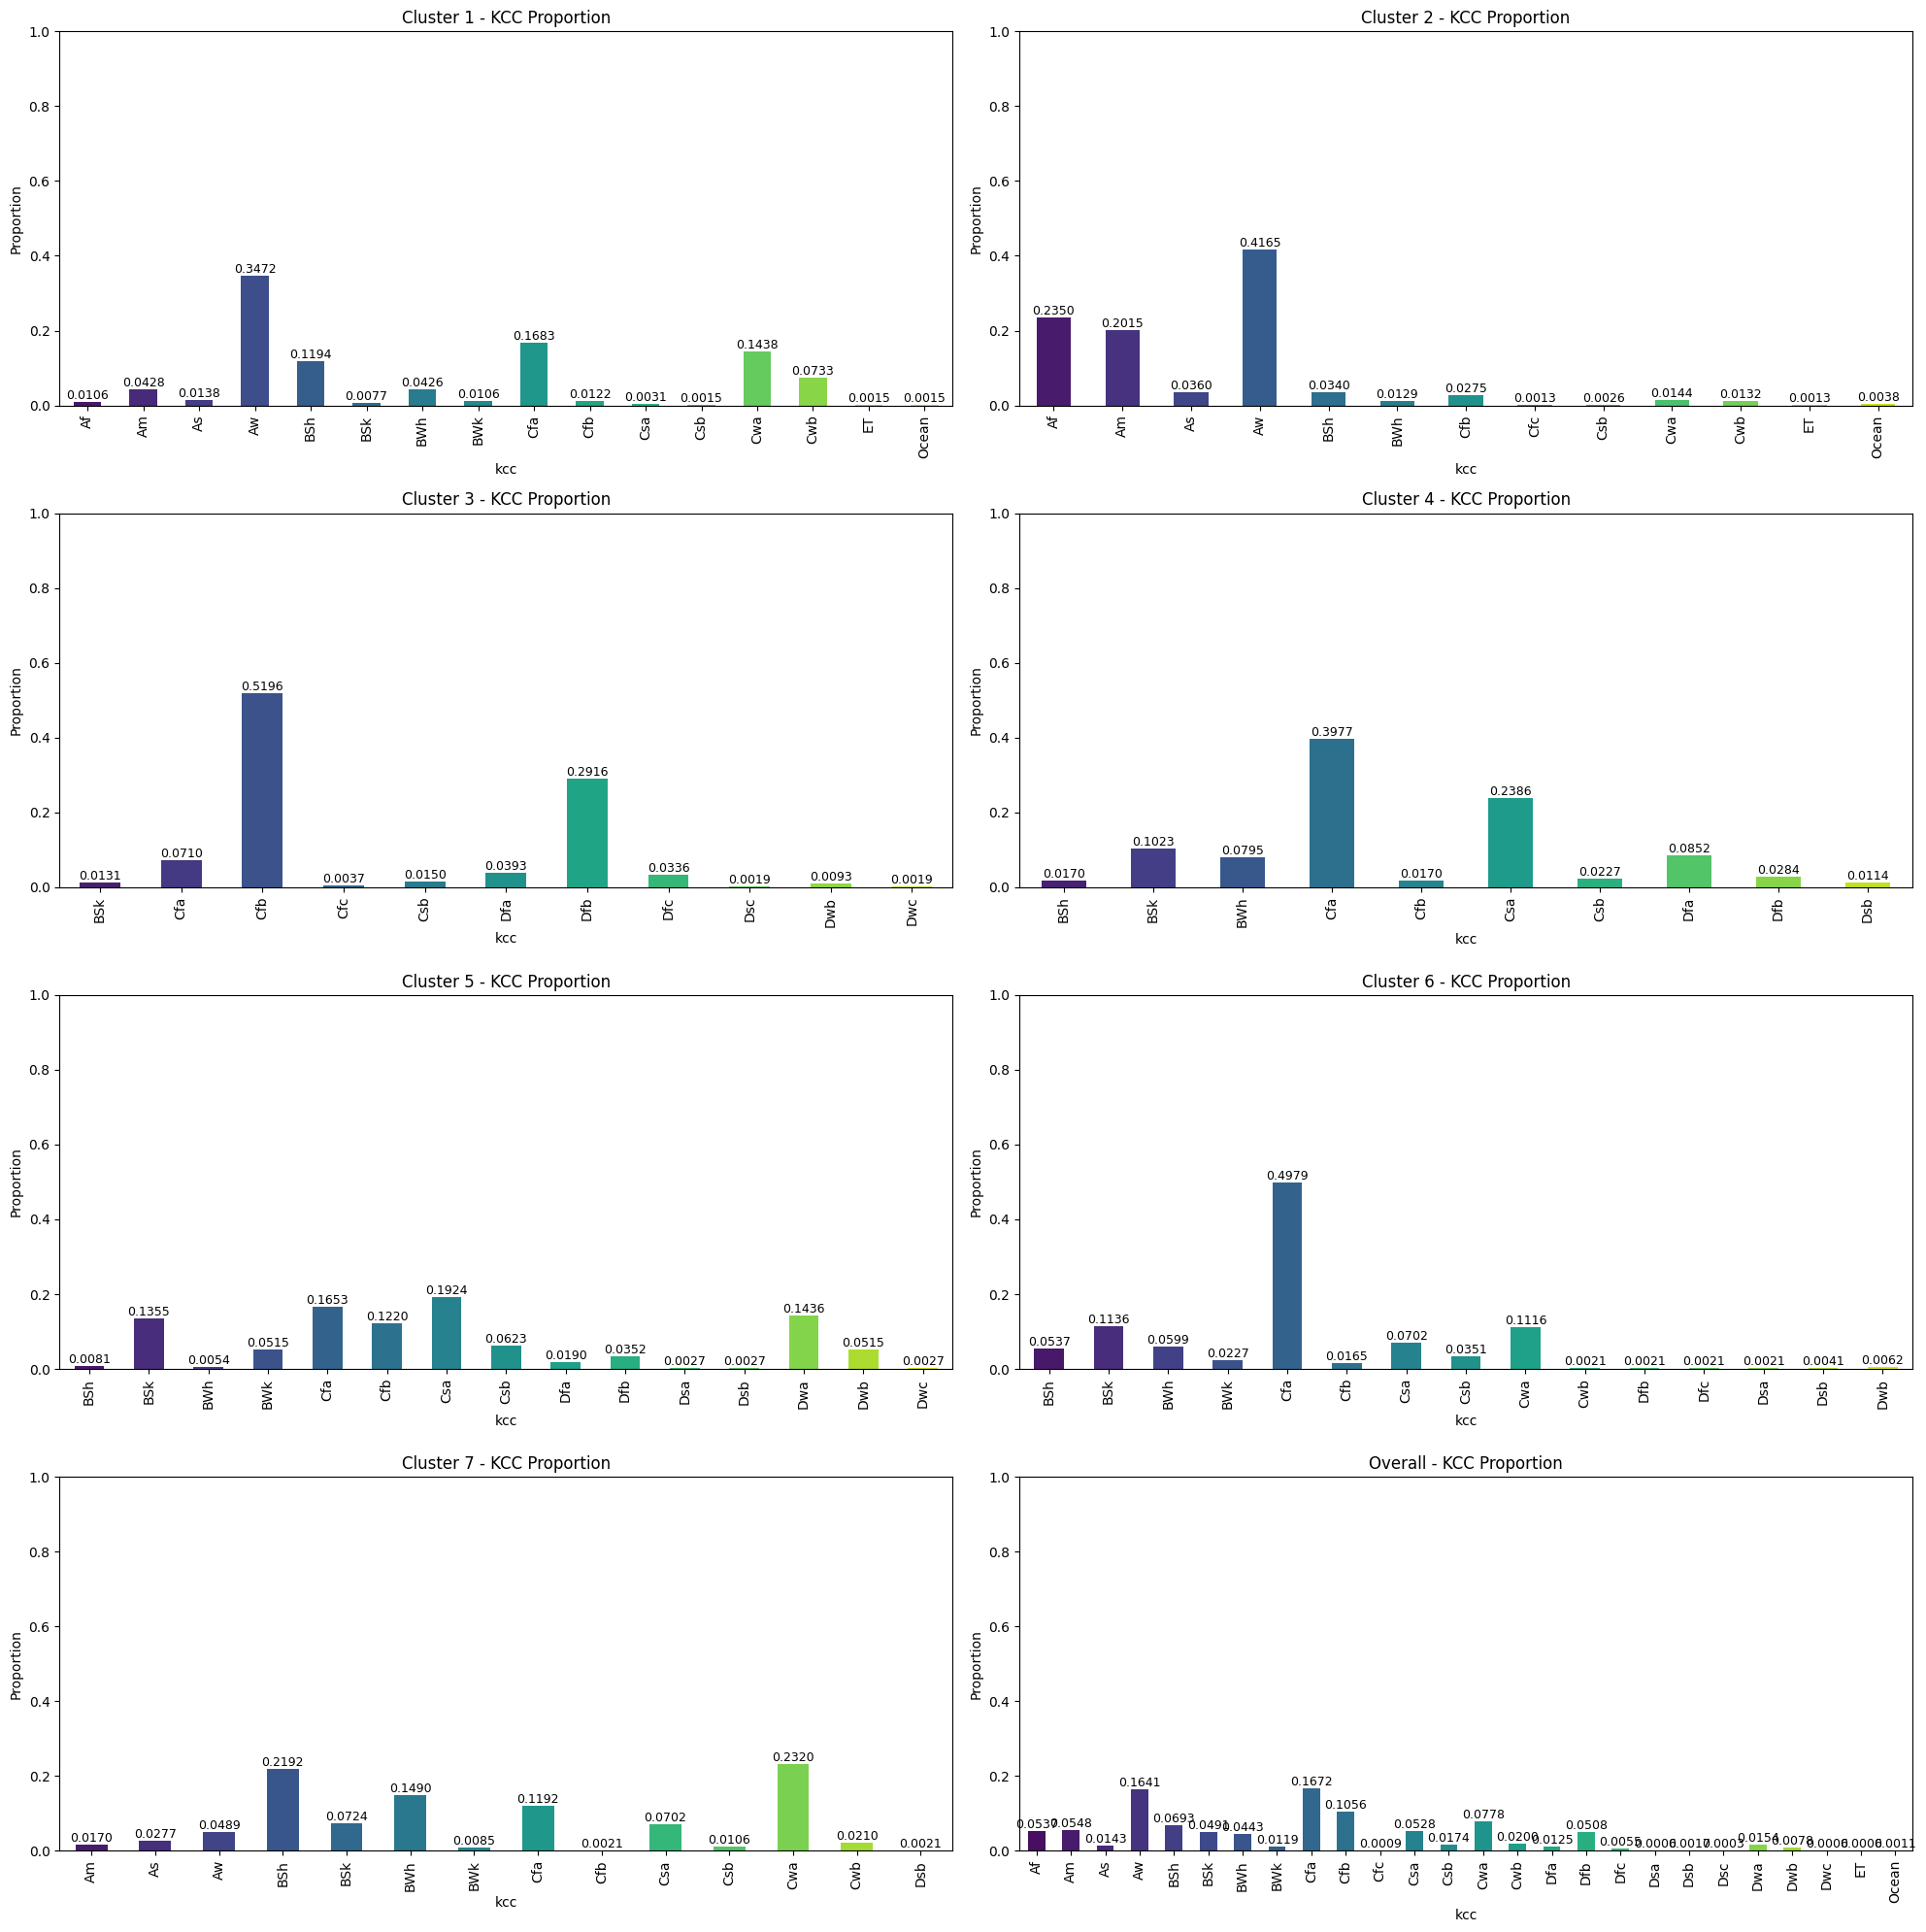

In [36]:
fig, axs = plt.subplots(4, 2, figsize=(20, 20))  # Adjusted layout
fig.subplots_adjust(hspace=0.7, wspace=0.5)

# Assuming clusters are numbered starting from 1 in df_merged
for i in range(1, n_clusters + 1):
    ax = axs.flat[i-1]  # Adjust index for 0-based indexing
    cluster_kcc_abundance = df_merged[df_merged['Cluster'] == i]['kcc'].value_counts(normalize=True).sort_index()
    cluster_kcc_abundance.plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(cluster_kcc_abundance)))
    ax.set_title(f'Cluster {i} - KCC Proportion')
    ax.set_ylabel('Proportion')
    ax.set_ylim(0, 1)
    add_labels(ax, cluster_kcc_abundance)

# Plot for overall KCC proportions
ax = axs.flat[n_clusters]  # Place overall proportions in the subplot right after the last cluster
overall_kcc_abundance = df_merged['kcc'].value_counts(normalize=True).sort_index()
overall_kcc_abundance.plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(overall_kcc_abundance)))
ax.set_title('Overall - KCC Proportion')
ax.set_ylabel('Proportion')
ax.set_ylim(0, 1)
add_labels(ax, overall_kcc_abundance)

# Disable any unused subplot(s) due to fixed grid size
for j in range(n_clusters + 1, len(axs.flat)):
    axs.flat[j].axis('off')

plt.tight_layout()
plt.show()


Visualize relative abundances of continent and kccs as a heatmap

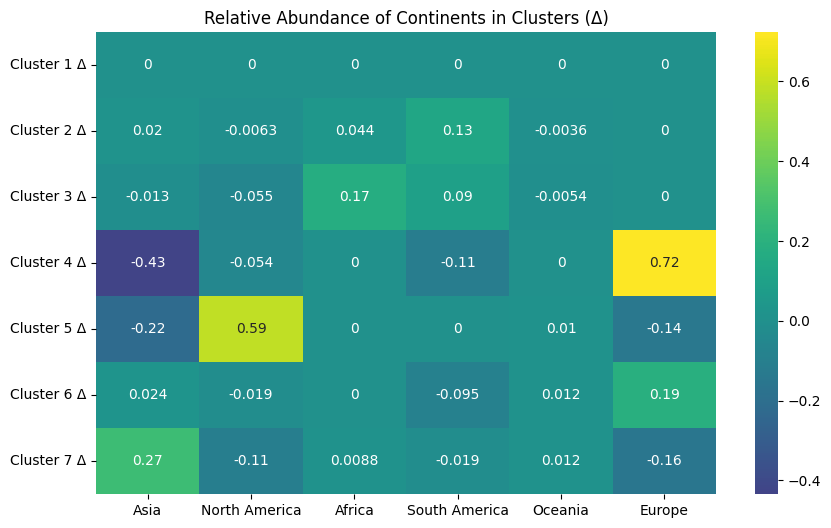

In [37]:
continents = df_hierarchical['Continent'].unique()
overall_continent_counts = df_hierarchical['Continent'].value_counts(normalize=True)

deltas = pd.DataFrame(index=continents)

for i in range(n_clusters):
    cluster_data = df_hierarchical[df_hierarchical['Cluster'] == i]
    continent_counts = cluster_data['Continent'].value_counts(normalize=True)
    deltas[f'Cluster {i+1} Δ'] = continent_counts - overall_continent_counts
deltas = deltas.transpose()
deltas.fillna(0, inplace=True)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(deltas, annot=True, cmap="viridis", center=0)
plt.title('Relative Abundance of Continents in Clusters (Δ)')
plt.show()

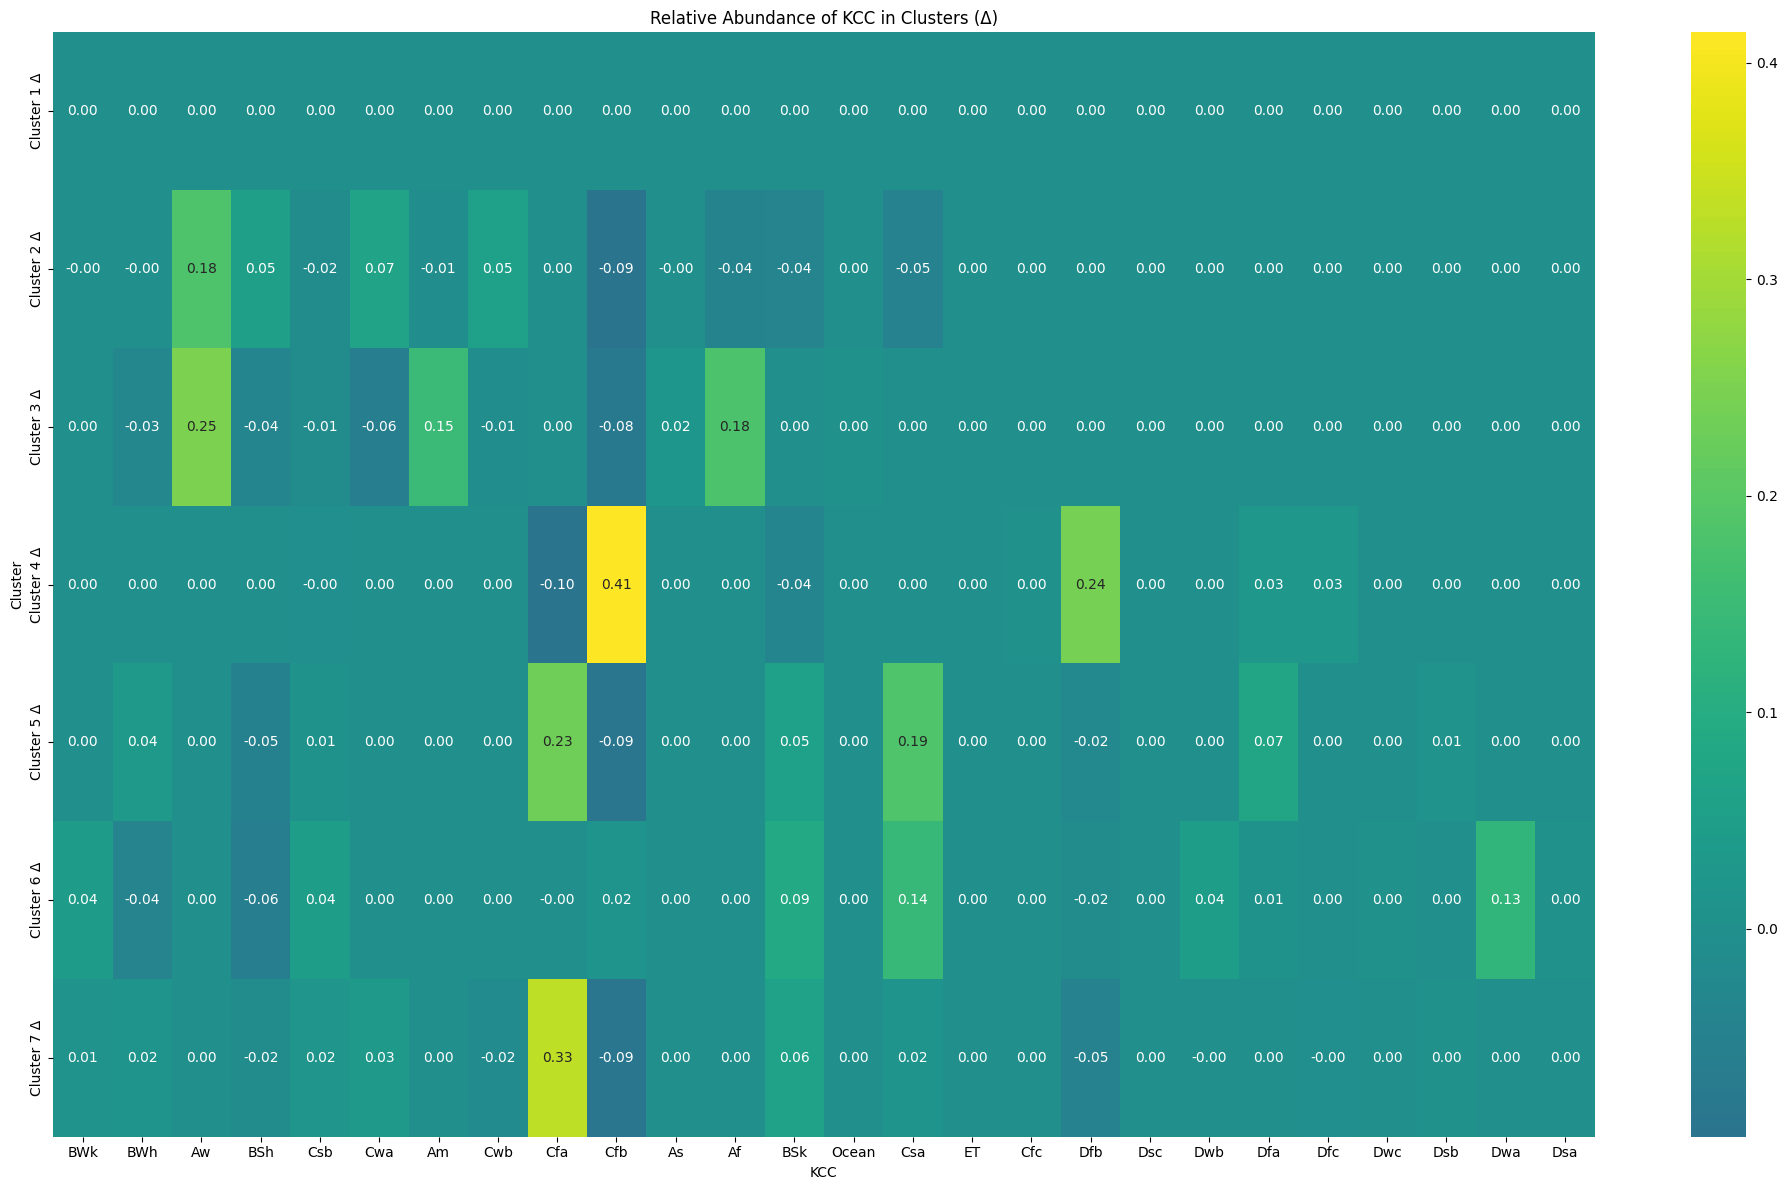

In [38]:
climates = df_hierarchical['kcc'].unique()
overall_climate_counts = df_hierarchical['kcc'].value_counts(normalize=True)

# Initialize a DataFrame to store the deltas
climate_deltas = pd.DataFrame(index=climates)

# Calculate deltas for each cluster
for i in range(n_clusters):
    cluster_data = df_hierarchical[df_hierarchical['Cluster'] == i]
    climate_counts = cluster_data['kcc'].value_counts(normalize=True)
    climate_deltas[f'Cluster {i+1} Δ'] = climate_counts - overall_climate_counts

# Transpose the DataFrame for easier plotting with seaborn
climate_deltas = climate_deltas.transpose()

# Replace NaN values with 0 (indicating no difference for missing climates in some clusters)
climate_deltas.fillna(0, inplace=True)

# Sort index for a cleaner look if necessary
climate_deltas.sort_index(inplace=True)

# Plot the heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(climate_deltas, annot=True, fmt=".2f", cmap="viridis", center=0)
plt.title('Relative Abundance of KCC in Clusters (Δ)')
plt.ylabel('Cluster')
plt.xlabel('KCC')
plt.tight_layout()
plt.show()

Geographic spread of clusters:

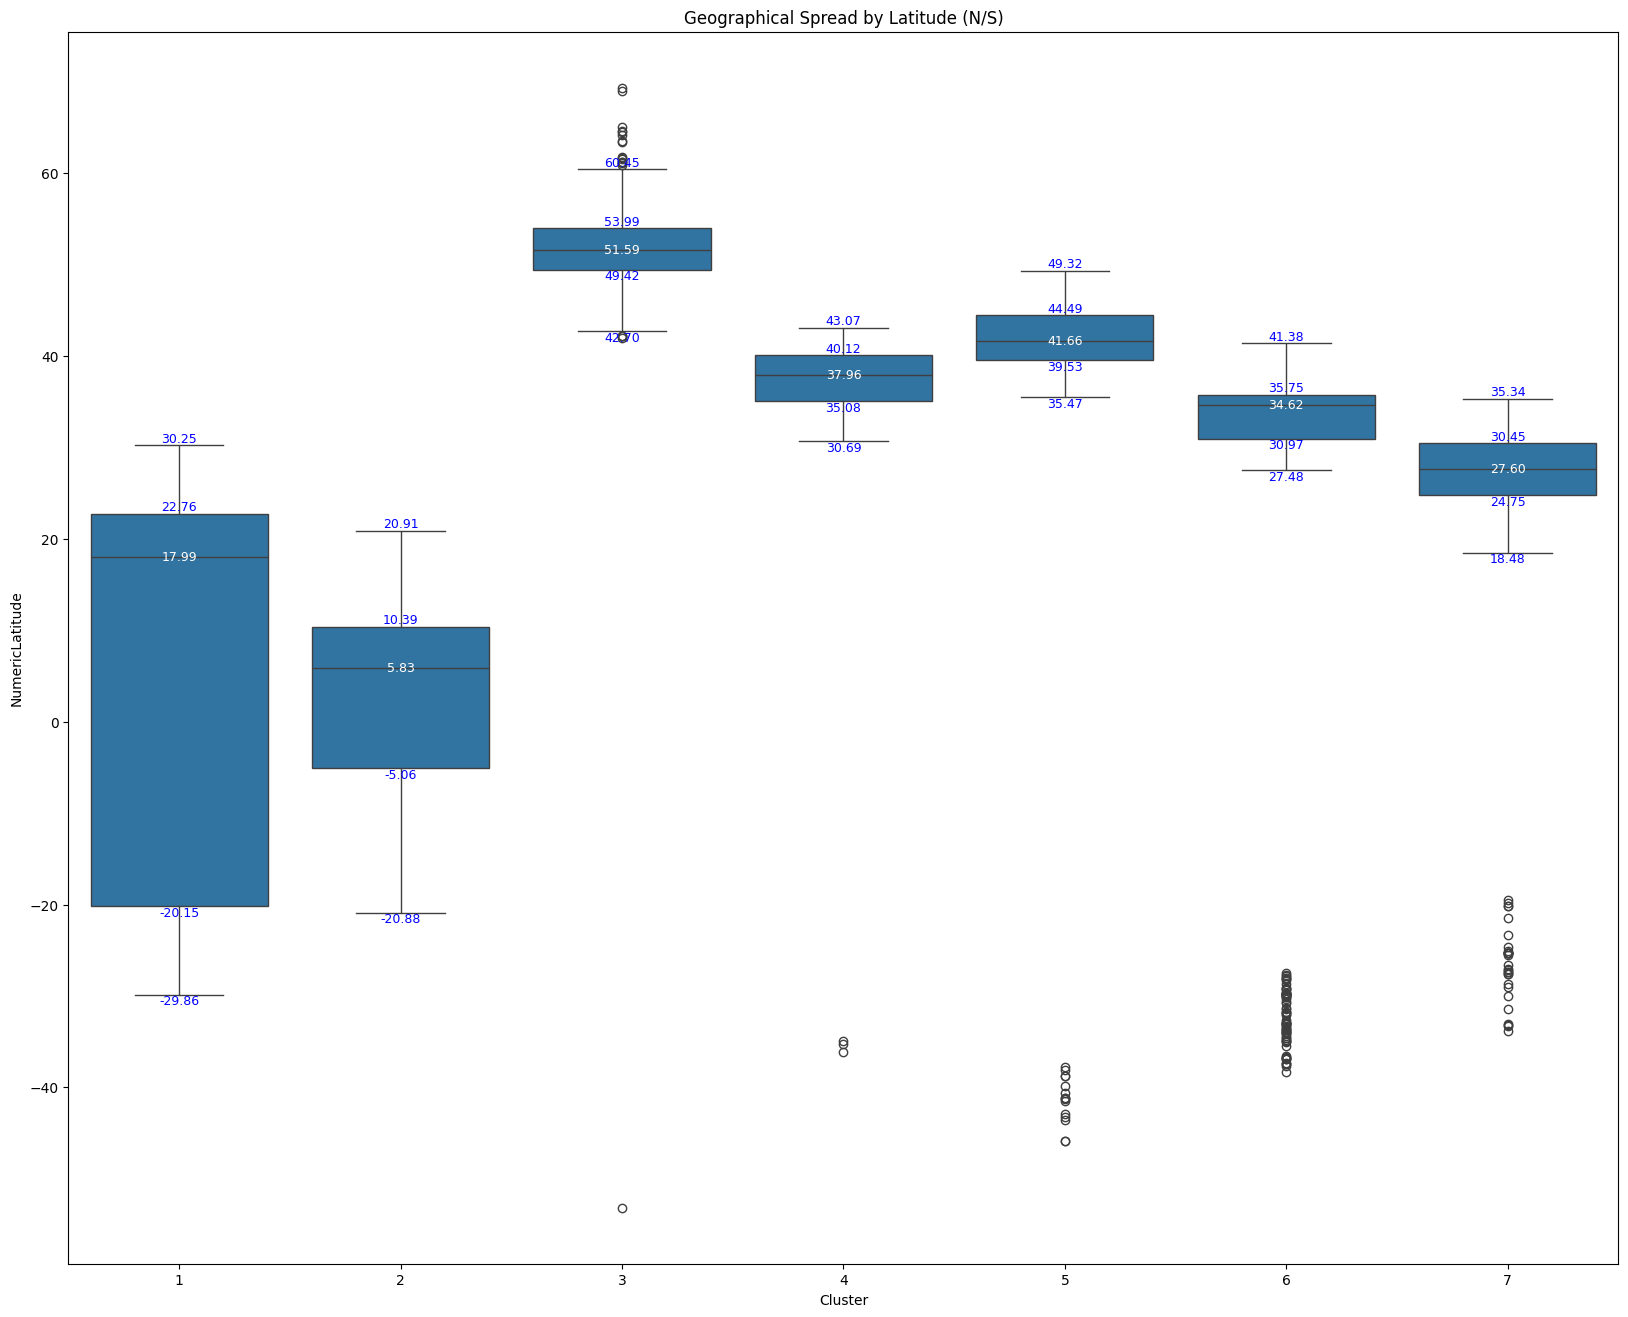

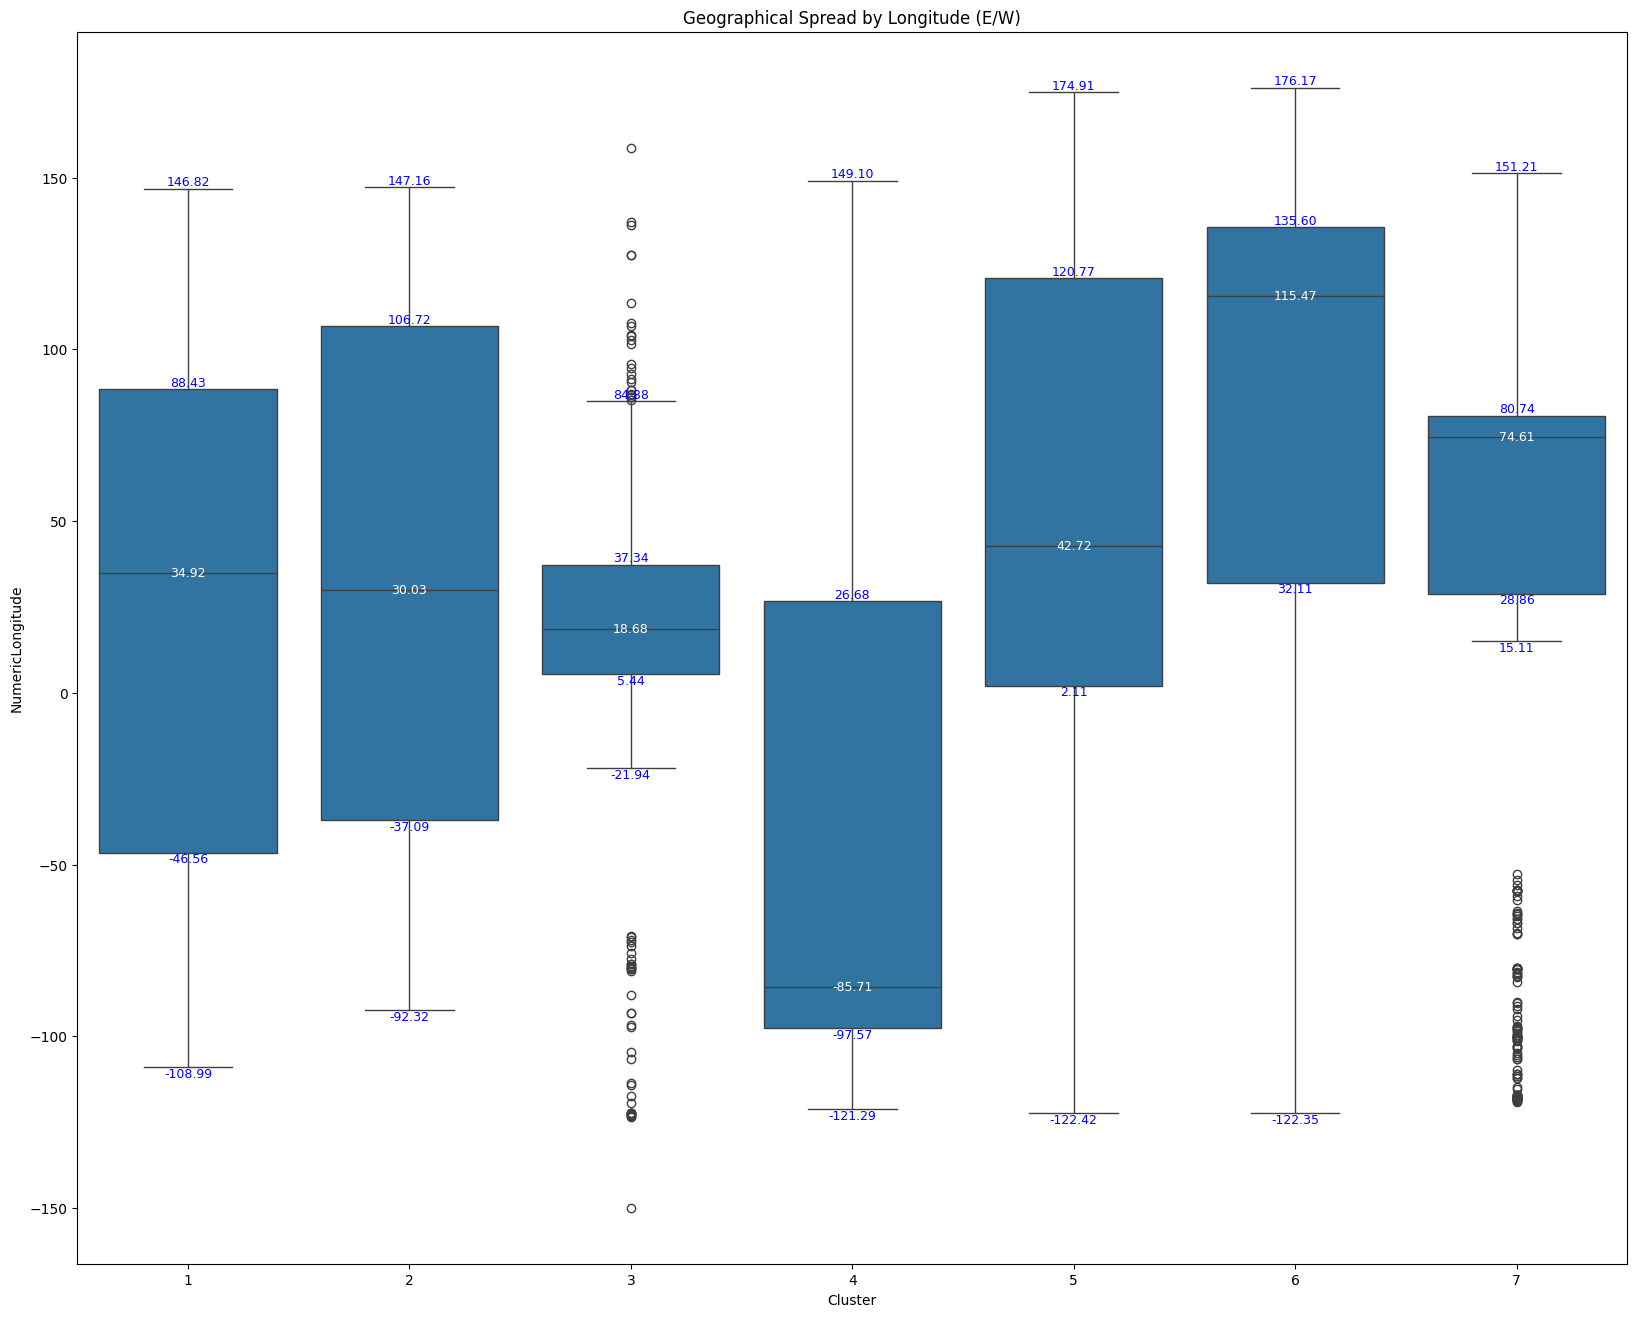

In [43]:
# Adjust this part to correctly reference cluster labels
unique_clusters = sorted(df_hierarchical['Cluster'].unique())

# Latitude
plt.figure(figsize=(20, 16))
sns.boxplot(x='Cluster', y='NumericLatitude', data=df_hierarchical)

for i, cluster_label in enumerate(unique_clusters):
    cluster_latitudes = df_hierarchical[df_hierarchical['Cluster'] == cluster_label]['NumericLatitude']
    percentiles = np.percentile(cluster_latitudes, [25, 50, 75])  # Q1, Median, Q3
    lower_whisker = np.min(cluster_latitudes[cluster_latitudes >= percentiles[0] - 1.5*(percentiles[2]-percentiles[0])])
    upper_whisker = np.max(cluster_latitudes[cluster_latitudes <= percentiles[2] + 1.5*(percentiles[2]-percentiles[0])])
    
    # Adjust the text annotations to use cluster_label for the x-position
    plt.text(i, lower_whisker, f'{lower_whisker:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(i, percentiles[0], f'{percentiles[0]:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(i, percentiles[1], f'{percentiles[1]:.2f}', ha='center', va='center', fontsize=9, color='white')
    plt.text(i, percentiles[2], f'{percentiles[2]:.2f}', ha='center', va='bottom', fontsize=9, color='blue')
    plt.text(i, upper_whisker, f'{upper_whisker:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

plt.title('Geographical Spread by Latitude (N/S)')
plt.ylabel('NumericLatitude')
plt.xlabel('Cluster')
plt.show()

# Longitude
plt.figure(figsize=(20, 16))
sns.boxplot(x='Cluster', y='NumericLongitude', data=df_hierarchical)
for i, cluster_label in enumerate(unique_clusters):
    cluster_Longitudes = df_hierarchical[df_hierarchical['Cluster'] == cluster_label]['NumericLongitude']
    percentiles = np.percentile(cluster_Longitudes, [25, 50, 75])
    lower_whisker = np.min(cluster_Longitudes[cluster_Longitudes >= percentiles[0] - 1.5*(percentiles[2]-percentiles[0])])
    upper_whisker = np.max(cluster_Longitudes[cluster_Longitudes <= percentiles[2] + 1.5*(percentiles[2]-percentiles[0])])
    
    # Adjust text annotations similarly
    plt.text(i, lower_whisker, f'{lower_whisker:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(i, percentiles[0], f'{percentiles[0]:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(i, percentiles[1], f'{percentiles[1]:.2f}', ha='center', va='center', fontsize=9, color='white')
    plt.text(i, percentiles[2], f'{percentiles[2]:.2f}', ha='center', va='bottom', fontsize=9, color='blue')
    plt.text(i, upper_whisker, f'{upper_whisker:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

plt.title('Geographical Spread by Longitude (E/W)')
plt.ylabel('NumericLongitude')
plt.xlabel('Cluster')
plt.show()
